## 04/03/2021

Same as before, optimise the latent size again, this time try an even larger latent space, jsut to get a better idea of how the network behaves. 


the training process of the autoencoder model takes a long time on this machine. For 5000 epochs, around an hour is required. 

The training result of this optimisation shows that the even larger latent space again had a negative impact on model performance. 

It seems that the initial guess of 10 for the latent space was pretty on point 



In [1]:
import torch 
import json 
import numpy as np 
from sklearn.model_selection import train_test_split 
from torch.utils.data import SubsetRandomSampler, DataLoader,TensorDataset
from tqdm import tqdm 
import torch.nn.functional as F
from torch import nn


In [10]:
DATA_PATH = "./data/synthetic/train_data.json"
TEST_PATH = "./data/synthetic/test_data.json"
EPOCHS = 300
BATCH_SIZE = 150
SAVED_MODEL_PATH = "./models/model3.pth"

In [3]:
def load_dataset(data_path):
    with open(data_path,"r") as fp: 
        data = json.load(fp)
    X = np.array(data["data"])
    y = np.array(data["labels"])
    return X, y 

def to_device(data,device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device)for x in data]
    else:
        return data.to(device, non_blocking = True)
    
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl 
        self.device = device 
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        return len(self.dl)
    
    
X,y=load_dataset(DATA_PATH)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
dataset = TensorDataset(X,y)
X_test, y_test = load_dataset(TEST_PATH)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
testset = TensorDataset(X_test,y_test)

train_dl = DataLoader(dataset, BATCH_SIZE, shuffle = True, drop_last=True)
test_dl = DataLoader(testset, BATCH_SIZE, shuffle = True, drop_last=True)

input_shape = dataset[0][0].shape
device = torch.device('cuda')
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [4]:
print(testset[0][0].shape)
print(type(dataset[0][0]))

torch.Size([1, 128, 16])
<class 'torch.Tensor'>


In [5]:
latent_size = 20 
# https://towardsdatascience.com/convolutional-autoencoders-for-image-noise-reduction-32fce9fc1763

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,stride = 2, padding=1 , kernel_size=3)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(32,64, stride = 2, padding =1, kernel_size=3)
        self.conv3 = nn.Conv2d(64,128,stride =2, padding =1, kernel_size = 3)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(4096,latent_size)
        self.fc = nn.Linear(latent_size,4096)
        self.deconv3 = nn.ConvTranspose2d(128,64,stride =2, kernel_size = 3, padding =1,output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(64,32,stride =2, kernel_size = 3,padding =1,output_padding=1)
        self.deconv1 = nn.ConvTranspose2d(32,1,stride =2, kernel_size = 3,padding =1,output_padding=1)
    
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.conv3(out)        
        out = self.relu(out)
        out = self.flatten(out)
        out = self.linear(out)
        out = self.relu(out)
        out = self.fc(out)
        out = self.relu(out)
        out = out.reshape(-1,128,16,2)
        out = self.deconv3(out)
        out = self.relu(out)
        out = self.deconv2(out)
        out = self.relu(out)
        out = self.deconv1(out)
        return out
autoencoder = Autoencoder()
autoencoder.to(device)
#autoencoder.load_state_dict(torch.load(SAVED_MODEL_PATH))

Autoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=4096, out_features=20, bias=True)
  (fc): Linear(in_features=20, out_features=4096, bias=True)
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv1): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

In [6]:
from torchsummary import summary 
summary(autoencoder, input_size = (1,128,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 64, 8]             320
         LeakyReLU-2            [-1, 32, 64, 8]               0
            Conv2d-3            [-1, 64, 32, 4]          18,496
         LeakyReLU-4            [-1, 64, 32, 4]               0
            Conv2d-5           [-1, 128, 16, 2]          73,856
         LeakyReLU-6           [-1, 128, 16, 2]               0
           Flatten-7                 [-1, 4096]               0
            Linear-8                   [-1, 20]          81,940
         LeakyReLU-9                   [-1, 20]               0
           Linear-10                 [-1, 4096]          86,016
        LeakyReLU-11                 [-1, 4096]               0
  ConvTranspose2d-12            [-1, 64, 32, 4]          73,792
        LeakyReLU-13            [-1, 64, 32, 4]               0
  ConvTranspose2d-14            [-1, 32

In [7]:

for images, labels in test_dl: 
    print("spectrogram shape: ", images.shape)
    out = autoencoder(images)
    
    print("output shape: ", out.shape)
    break 
    
img = out[0][0].detach().cpu()
print(img.shape)
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.imshow(img, aspect = 'auto')


spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 1, 128, 16])
torch.Size([128, 16])


## Now start training and see what the resulting image would look like 


In [8]:
criterion = nn.MSELoss()
ae_opt= torch.optim.Adam(autoencoder.parameters(), lr = 0.0002)


In [9]:
loss_list = []
EPOCHS = 5000
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_dl):
        reconstructed = autoencoder(images)
        loss = criterion(images, reconstructed)
        
        ae_opt.zero_grad()
        loss.backward()
        ae_opt.step()
    
    loss_list.append(np.sum(loss.item()))
    
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, EPOCHS, loss.item()))

        


epoch [1/5000], loss:130.4595
epoch [2/5000], loss:123.2207
epoch [3/5000], loss:105.8844
epoch [4/5000], loss:84.4072
epoch [5/5000], loss:69.7940
epoch [6/5000], loss:67.3221
epoch [7/5000], loss:64.4635
epoch [8/5000], loss:62.0607
epoch [9/5000], loss:55.5590
epoch [10/5000], loss:53.0284
epoch [11/5000], loss:57.5345
epoch [12/5000], loss:53.7704
epoch [13/5000], loss:60.7156
epoch [14/5000], loss:54.5412
epoch [15/5000], loss:57.0367
epoch [16/5000], loss:54.1450
epoch [17/5000], loss:56.1554
epoch [18/5000], loss:54.4389
epoch [19/5000], loss:52.2109
epoch [20/5000], loss:50.3982
epoch [21/5000], loss:55.3722
epoch [22/5000], loss:54.8960
epoch [23/5000], loss:51.7882
epoch [24/5000], loss:48.2023
epoch [25/5000], loss:49.6721
epoch [26/5000], loss:54.2040
epoch [27/5000], loss:46.1107
epoch [28/5000], loss:52.5356
epoch [29/5000], loss:44.3037
epoch [30/5000], loss:55.8139
epoch [31/5000], loss:45.6313
epoch [32/5000], loss:49.8808
epoch [33/5000], loss:50.1316
epoch [34/5000],

epoch [269/5000], loss:28.4294
epoch [270/5000], loss:28.6224
epoch [271/5000], loss:28.6713
epoch [272/5000], loss:28.5311
epoch [273/5000], loss:28.2205
epoch [274/5000], loss:28.4088
epoch [275/5000], loss:28.1906
epoch [276/5000], loss:28.3575
epoch [277/5000], loss:28.2999
epoch [278/5000], loss:28.4626
epoch [279/5000], loss:28.5733
epoch [280/5000], loss:28.0655
epoch [281/5000], loss:28.2992
epoch [282/5000], loss:28.2411
epoch [283/5000], loss:28.4090
epoch [284/5000], loss:28.4522
epoch [285/5000], loss:28.6231
epoch [286/5000], loss:28.2033
epoch [287/5000], loss:28.5432
epoch [288/5000], loss:28.3595
epoch [289/5000], loss:28.6736
epoch [290/5000], loss:28.2131
epoch [291/5000], loss:28.5607
epoch [292/5000], loss:28.0931
epoch [293/5000], loss:28.4832
epoch [294/5000], loss:28.2212
epoch [295/5000], loss:28.2982
epoch [296/5000], loss:27.8377
epoch [297/5000], loss:28.2816
epoch [298/5000], loss:28.3447
epoch [299/5000], loss:28.2703
epoch [300/5000], loss:28.1367
epoch [3

epoch [534/5000], loss:27.3664
epoch [535/5000], loss:27.4226
epoch [536/5000], loss:27.4132
epoch [537/5000], loss:27.1621
epoch [538/5000], loss:27.1275
epoch [539/5000], loss:27.5257
epoch [540/5000], loss:27.3686
epoch [541/5000], loss:27.3197
epoch [542/5000], loss:27.0366
epoch [543/5000], loss:27.3842
epoch [544/5000], loss:27.3444
epoch [545/5000], loss:27.3591
epoch [546/5000], loss:27.1253
epoch [547/5000], loss:27.0609
epoch [548/5000], loss:27.2813
epoch [549/5000], loss:27.0118
epoch [550/5000], loss:27.1352
epoch [551/5000], loss:27.2495
epoch [552/5000], loss:27.3189
epoch [553/5000], loss:27.2987
epoch [554/5000], loss:27.1471
epoch [555/5000], loss:27.0778
epoch [556/5000], loss:27.0817
epoch [557/5000], loss:27.5775
epoch [558/5000], loss:27.1410
epoch [559/5000], loss:27.1286
epoch [560/5000], loss:27.2435
epoch [561/5000], loss:27.2711
epoch [562/5000], loss:27.2966
epoch [563/5000], loss:27.3035
epoch [564/5000], loss:27.0228
epoch [565/5000], loss:27.1228
epoch [5

epoch [799/5000], loss:26.5523
epoch [800/5000], loss:26.6927
epoch [801/5000], loss:25.9118
epoch [802/5000], loss:26.5402
epoch [803/5000], loss:26.2756
epoch [804/5000], loss:25.8945
epoch [805/5000], loss:26.1648
epoch [806/5000], loss:26.4020
epoch [807/5000], loss:26.1488
epoch [808/5000], loss:26.4268
epoch [809/5000], loss:26.1694
epoch [810/5000], loss:26.3307
epoch [811/5000], loss:26.4731
epoch [812/5000], loss:26.3131
epoch [813/5000], loss:25.8512
epoch [814/5000], loss:26.2532
epoch [815/5000], loss:26.2690
epoch [816/5000], loss:26.4552
epoch [817/5000], loss:26.4491
epoch [818/5000], loss:26.6328
epoch [819/5000], loss:26.1299
epoch [820/5000], loss:26.0570
epoch [821/5000], loss:26.2560
epoch [822/5000], loss:26.1630
epoch [823/5000], loss:26.2726
epoch [824/5000], loss:26.0418
epoch [825/5000], loss:26.3140
epoch [826/5000], loss:26.2906
epoch [827/5000], loss:26.5149
epoch [828/5000], loss:26.2711
epoch [829/5000], loss:26.3213
epoch [830/5000], loss:26.4722
epoch [8

epoch [1062/5000], loss:25.7069
epoch [1063/5000], loss:25.6088
epoch [1064/5000], loss:25.6838
epoch [1065/5000], loss:25.5323
epoch [1066/5000], loss:25.2929
epoch [1067/5000], loss:25.8597
epoch [1068/5000], loss:25.6157
epoch [1069/5000], loss:25.5322
epoch [1070/5000], loss:25.5682
epoch [1071/5000], loss:25.5961
epoch [1072/5000], loss:25.7547
epoch [1073/5000], loss:25.7264
epoch [1074/5000], loss:25.5004
epoch [1075/5000], loss:25.6602
epoch [1076/5000], loss:25.5452
epoch [1077/5000], loss:25.4212
epoch [1078/5000], loss:25.5252
epoch [1079/5000], loss:25.7284
epoch [1080/5000], loss:25.4990
epoch [1081/5000], loss:25.7409
epoch [1082/5000], loss:25.5341
epoch [1083/5000], loss:25.6750
epoch [1084/5000], loss:25.3211
epoch [1085/5000], loss:26.1518
epoch [1086/5000], loss:25.5618
epoch [1087/5000], loss:25.9015
epoch [1088/5000], loss:26.0745
epoch [1089/5000], loss:25.5650
epoch [1090/5000], loss:25.8587
epoch [1091/5000], loss:25.6439
epoch [1092/5000], loss:25.3891
epoch [1

epoch [1319/5000], loss:25.1277
epoch [1320/5000], loss:25.0779
epoch [1321/5000], loss:24.9294
epoch [1322/5000], loss:25.0883
epoch [1323/5000], loss:24.9264
epoch [1324/5000], loss:24.9852
epoch [1325/5000], loss:25.1228
epoch [1326/5000], loss:25.1962
epoch [1327/5000], loss:24.7510
epoch [1328/5000], loss:24.9265
epoch [1329/5000], loss:25.2039
epoch [1330/5000], loss:25.0063
epoch [1331/5000], loss:25.3621
epoch [1332/5000], loss:24.4606
epoch [1333/5000], loss:24.8718
epoch [1334/5000], loss:25.2344
epoch [1335/5000], loss:24.8815
epoch [1336/5000], loss:24.7403
epoch [1337/5000], loss:25.2950
epoch [1338/5000], loss:25.1513
epoch [1339/5000], loss:25.1216
epoch [1340/5000], loss:24.9161
epoch [1341/5000], loss:25.1522
epoch [1342/5000], loss:25.2879
epoch [1343/5000], loss:25.1320
epoch [1344/5000], loss:25.1203
epoch [1345/5000], loss:24.8738
epoch [1346/5000], loss:24.7464
epoch [1347/5000], loss:24.9069
epoch [1348/5000], loss:25.2515
epoch [1349/5000], loss:24.6377
epoch [1

epoch [1576/5000], loss:24.4245
epoch [1577/5000], loss:24.4148
epoch [1578/5000], loss:24.6570
epoch [1579/5000], loss:24.6891
epoch [1580/5000], loss:24.8012
epoch [1581/5000], loss:24.5511
epoch [1582/5000], loss:24.1409
epoch [1583/5000], loss:24.8606
epoch [1584/5000], loss:25.0002
epoch [1585/5000], loss:24.4742
epoch [1586/5000], loss:24.6326
epoch [1587/5000], loss:24.9190
epoch [1588/5000], loss:24.4894
epoch [1589/5000], loss:24.4958
epoch [1590/5000], loss:24.4161
epoch [1591/5000], loss:24.5117
epoch [1592/5000], loss:24.5562
epoch [1593/5000], loss:24.3577
epoch [1594/5000], loss:24.4140
epoch [1595/5000], loss:24.5877
epoch [1596/5000], loss:24.4828
epoch [1597/5000], loss:24.8844
epoch [1598/5000], loss:24.3735
epoch [1599/5000], loss:24.8517
epoch [1600/5000], loss:24.6414
epoch [1601/5000], loss:24.4161
epoch [1602/5000], loss:24.2845
epoch [1603/5000], loss:24.5236
epoch [1604/5000], loss:24.4141
epoch [1605/5000], loss:24.5745
epoch [1606/5000], loss:24.3599
epoch [1

epoch [1833/5000], loss:24.2053
epoch [1834/5000], loss:23.8303
epoch [1835/5000], loss:24.1109
epoch [1836/5000], loss:23.6353
epoch [1837/5000], loss:23.6520
epoch [1838/5000], loss:23.9373
epoch [1839/5000], loss:24.3483
epoch [1840/5000], loss:23.9969
epoch [1841/5000], loss:24.1742
epoch [1842/5000], loss:23.7130
epoch [1843/5000], loss:24.2937
epoch [1844/5000], loss:23.8384
epoch [1845/5000], loss:23.8578
epoch [1846/5000], loss:24.0450
epoch [1847/5000], loss:24.5041
epoch [1848/5000], loss:24.2522
epoch [1849/5000], loss:24.1899
epoch [1850/5000], loss:24.2677
epoch [1851/5000], loss:24.1179
epoch [1852/5000], loss:24.1303
epoch [1853/5000], loss:24.3494
epoch [1854/5000], loss:24.4080
epoch [1855/5000], loss:24.5514
epoch [1856/5000], loss:23.9256
epoch [1857/5000], loss:24.0035
epoch [1858/5000], loss:23.9844
epoch [1859/5000], loss:23.9687
epoch [1860/5000], loss:24.0272
epoch [1861/5000], loss:24.0072
epoch [1862/5000], loss:24.1216
epoch [1863/5000], loss:24.3441
epoch [1

epoch [2090/5000], loss:23.9077
epoch [2091/5000], loss:23.8711
epoch [2092/5000], loss:23.5828
epoch [2093/5000], loss:24.3648
epoch [2094/5000], loss:24.1979
epoch [2095/5000], loss:23.7092
epoch [2096/5000], loss:24.0096
epoch [2097/5000], loss:23.8204
epoch [2098/5000], loss:23.8979
epoch [2099/5000], loss:23.8703
epoch [2100/5000], loss:23.9096
epoch [2101/5000], loss:23.6650
epoch [2102/5000], loss:23.6047
epoch [2103/5000], loss:23.9172
epoch [2104/5000], loss:24.0348
epoch [2105/5000], loss:23.9375
epoch [2106/5000], loss:23.7531
epoch [2107/5000], loss:23.8180
epoch [2108/5000], loss:23.7271
epoch [2109/5000], loss:23.9010
epoch [2110/5000], loss:24.0074
epoch [2111/5000], loss:23.8256
epoch [2112/5000], loss:23.7781
epoch [2113/5000], loss:23.9092
epoch [2114/5000], loss:23.4981
epoch [2115/5000], loss:23.8982
epoch [2116/5000], loss:23.0995
epoch [2117/5000], loss:23.9162
epoch [2118/5000], loss:24.0246
epoch [2119/5000], loss:23.8881
epoch [2120/5000], loss:23.9492
epoch [2

epoch [2347/5000], loss:23.5581
epoch [2348/5000], loss:23.5626
epoch [2349/5000], loss:23.4673
epoch [2350/5000], loss:23.2820
epoch [2351/5000], loss:23.7232
epoch [2352/5000], loss:23.4574
epoch [2353/5000], loss:23.5399
epoch [2354/5000], loss:23.1104
epoch [2355/5000], loss:23.3759
epoch [2356/5000], loss:23.0012
epoch [2357/5000], loss:23.4400
epoch [2358/5000], loss:23.7541
epoch [2359/5000], loss:23.5186
epoch [2360/5000], loss:23.6266
epoch [2361/5000], loss:23.7475
epoch [2362/5000], loss:23.5320
epoch [2363/5000], loss:23.4519
epoch [2364/5000], loss:23.1583
epoch [2365/5000], loss:23.4353
epoch [2366/5000], loss:23.7324
epoch [2367/5000], loss:23.9342
epoch [2368/5000], loss:23.3242
epoch [2369/5000], loss:23.3819
epoch [2370/5000], loss:23.4422
epoch [2371/5000], loss:23.5053
epoch [2372/5000], loss:23.5953
epoch [2373/5000], loss:23.2344
epoch [2374/5000], loss:23.7900
epoch [2375/5000], loss:23.2423
epoch [2376/5000], loss:23.7199
epoch [2377/5000], loss:23.0371
epoch [2

epoch [2604/5000], loss:23.2846
epoch [2605/5000], loss:23.2624
epoch [2606/5000], loss:22.9382
epoch [2607/5000], loss:23.1941
epoch [2608/5000], loss:23.4673
epoch [2609/5000], loss:23.4053
epoch [2610/5000], loss:23.3060
epoch [2611/5000], loss:23.5746
epoch [2612/5000], loss:22.8347
epoch [2613/5000], loss:23.2605
epoch [2614/5000], loss:23.4026
epoch [2615/5000], loss:22.9366
epoch [2616/5000], loss:22.9479
epoch [2617/5000], loss:23.2506
epoch [2618/5000], loss:23.3918
epoch [2619/5000], loss:23.1101
epoch [2620/5000], loss:23.2794
epoch [2621/5000], loss:23.2448
epoch [2622/5000], loss:23.3758
epoch [2623/5000], loss:23.3787
epoch [2624/5000], loss:23.4058
epoch [2625/5000], loss:23.1642
epoch [2626/5000], loss:23.1336
epoch [2627/5000], loss:22.9400
epoch [2628/5000], loss:23.2778
epoch [2629/5000], loss:23.4027
epoch [2630/5000], loss:23.3459
epoch [2631/5000], loss:23.4377
epoch [2632/5000], loss:23.5351
epoch [2633/5000], loss:23.3122
epoch [2634/5000], loss:23.2838
epoch [2

epoch [2861/5000], loss:22.9644
epoch [2862/5000], loss:23.1167
epoch [2863/5000], loss:23.0000
epoch [2864/5000], loss:22.5862
epoch [2865/5000], loss:23.2878
epoch [2866/5000], loss:22.7752
epoch [2867/5000], loss:22.7509
epoch [2868/5000], loss:23.1189
epoch [2869/5000], loss:23.4264
epoch [2870/5000], loss:23.0099
epoch [2871/5000], loss:23.2968
epoch [2872/5000], loss:22.8973
epoch [2873/5000], loss:23.1729
epoch [2874/5000], loss:23.2055
epoch [2875/5000], loss:23.3908
epoch [2876/5000], loss:23.0453
epoch [2877/5000], loss:22.8854
epoch [2878/5000], loss:23.0682
epoch [2879/5000], loss:22.9137
epoch [2880/5000], loss:23.0037
epoch [2881/5000], loss:22.6096
epoch [2882/5000], loss:23.0902
epoch [2883/5000], loss:23.5537
epoch [2884/5000], loss:23.1090
epoch [2885/5000], loss:23.3191
epoch [2886/5000], loss:23.2883
epoch [2887/5000], loss:22.8840
epoch [2888/5000], loss:22.7367
epoch [2889/5000], loss:22.8820
epoch [2890/5000], loss:22.7398
epoch [2891/5000], loss:22.9406
epoch [2

epoch [3118/5000], loss:22.7885
epoch [3119/5000], loss:22.5533
epoch [3120/5000], loss:23.1105
epoch [3121/5000], loss:22.9959
epoch [3122/5000], loss:22.7360
epoch [3123/5000], loss:23.1747
epoch [3124/5000], loss:22.8436
epoch [3125/5000], loss:22.7046
epoch [3126/5000], loss:23.0937
epoch [3127/5000], loss:22.8410
epoch [3128/5000], loss:23.3141
epoch [3129/5000], loss:22.8299
epoch [3130/5000], loss:22.8322
epoch [3131/5000], loss:22.5778
epoch [3132/5000], loss:22.7926
epoch [3133/5000], loss:22.7065
epoch [3134/5000], loss:23.2147
epoch [3135/5000], loss:22.4055
epoch [3136/5000], loss:22.5380
epoch [3137/5000], loss:23.1495
epoch [3138/5000], loss:22.9852
epoch [3139/5000], loss:22.5175
epoch [3140/5000], loss:22.8443
epoch [3141/5000], loss:22.8809
epoch [3142/5000], loss:23.0093
epoch [3143/5000], loss:22.6214
epoch [3144/5000], loss:22.6135
epoch [3145/5000], loss:22.7454
epoch [3146/5000], loss:22.7680
epoch [3147/5000], loss:22.9711
epoch [3148/5000], loss:22.4576
epoch [3

epoch [3375/5000], loss:22.5525
epoch [3376/5000], loss:22.7940
epoch [3377/5000], loss:22.6396
epoch [3378/5000], loss:22.7459
epoch [3379/5000], loss:22.5440
epoch [3380/5000], loss:22.6328
epoch [3381/5000], loss:22.6872
epoch [3382/5000], loss:22.2581
epoch [3383/5000], loss:22.4221
epoch [3384/5000], loss:22.4802
epoch [3385/5000], loss:22.4732
epoch [3386/5000], loss:22.5618
epoch [3387/5000], loss:22.6021
epoch [3388/5000], loss:22.6098
epoch [3389/5000], loss:22.6770
epoch [3390/5000], loss:22.2893
epoch [3391/5000], loss:22.1260
epoch [3392/5000], loss:22.2835
epoch [3393/5000], loss:22.8771
epoch [3394/5000], loss:22.7013
epoch [3395/5000], loss:23.1107
epoch [3396/5000], loss:22.7016
epoch [3397/5000], loss:22.5548
epoch [3398/5000], loss:22.6455
epoch [3399/5000], loss:22.1622
epoch [3400/5000], loss:22.2397
epoch [3401/5000], loss:21.8660
epoch [3402/5000], loss:22.6632
epoch [3403/5000], loss:22.5004
epoch [3404/5000], loss:22.3067
epoch [3405/5000], loss:23.1023
epoch [3

epoch [3632/5000], loss:22.5175
epoch [3633/5000], loss:22.4305
epoch [3634/5000], loss:22.7086
epoch [3635/5000], loss:22.5854
epoch [3636/5000], loss:22.2099
epoch [3637/5000], loss:22.2318
epoch [3638/5000], loss:22.1688
epoch [3639/5000], loss:22.5129
epoch [3640/5000], loss:22.6816
epoch [3641/5000], loss:22.2443
epoch [3642/5000], loss:22.4323
epoch [3643/5000], loss:22.3693
epoch [3644/5000], loss:22.3702
epoch [3645/5000], loss:22.3942
epoch [3646/5000], loss:22.1321
epoch [3647/5000], loss:23.0269
epoch [3648/5000], loss:22.4297
epoch [3649/5000], loss:22.3507
epoch [3650/5000], loss:22.4448
epoch [3651/5000], loss:22.1024
epoch [3652/5000], loss:22.0917
epoch [3653/5000], loss:22.0808
epoch [3654/5000], loss:22.6694
epoch [3655/5000], loss:22.3379
epoch [3656/5000], loss:22.4293
epoch [3657/5000], loss:22.5756
epoch [3658/5000], loss:22.3462
epoch [3659/5000], loss:22.1956
epoch [3660/5000], loss:22.3204
epoch [3661/5000], loss:21.8117
epoch [3662/5000], loss:22.3857
epoch [3

epoch [3889/5000], loss:22.3217
epoch [3890/5000], loss:22.3871
epoch [3891/5000], loss:22.0256
epoch [3892/5000], loss:21.9834
epoch [3893/5000], loss:21.6648
epoch [3894/5000], loss:22.0189
epoch [3895/5000], loss:22.1575
epoch [3896/5000], loss:22.3066
epoch [3897/5000], loss:22.4474
epoch [3898/5000], loss:22.3225
epoch [3899/5000], loss:21.9229
epoch [3900/5000], loss:22.1398
epoch [3901/5000], loss:22.3166
epoch [3902/5000], loss:21.9113
epoch [3903/5000], loss:21.6469
epoch [3904/5000], loss:22.1109
epoch [3905/5000], loss:22.3626
epoch [3906/5000], loss:22.5063
epoch [3907/5000], loss:22.2136
epoch [3908/5000], loss:22.2919
epoch [3909/5000], loss:22.4062
epoch [3910/5000], loss:21.8469
epoch [3911/5000], loss:22.2744
epoch [3912/5000], loss:22.0631
epoch [3913/5000], loss:21.8135
epoch [3914/5000], loss:21.7022
epoch [3915/5000], loss:22.0747
epoch [3916/5000], loss:21.9324
epoch [3917/5000], loss:22.5020
epoch [3918/5000], loss:22.5109
epoch [3919/5000], loss:22.5363
epoch [3

epoch [4146/5000], loss:21.9930
epoch [4147/5000], loss:22.4411
epoch [4148/5000], loss:22.2711
epoch [4149/5000], loss:22.3008
epoch [4150/5000], loss:22.5232
epoch [4151/5000], loss:22.2937
epoch [4152/5000], loss:21.8436
epoch [4153/5000], loss:22.2569
epoch [4154/5000], loss:21.9422
epoch [4155/5000], loss:22.3175
epoch [4156/5000], loss:22.0382
epoch [4157/5000], loss:22.0550
epoch [4158/5000], loss:21.9027
epoch [4159/5000], loss:21.9007
epoch [4160/5000], loss:21.8563
epoch [4161/5000], loss:22.1547
epoch [4162/5000], loss:22.5294
epoch [4163/5000], loss:22.2013
epoch [4164/5000], loss:22.2121
epoch [4165/5000], loss:21.8668
epoch [4166/5000], loss:22.1229
epoch [4167/5000], loss:21.9703
epoch [4168/5000], loss:22.4223
epoch [4169/5000], loss:21.9071
epoch [4170/5000], loss:21.8819
epoch [4171/5000], loss:22.0872
epoch [4172/5000], loss:22.1636
epoch [4173/5000], loss:21.9224
epoch [4174/5000], loss:22.3012
epoch [4175/5000], loss:21.9266
epoch [4176/5000], loss:22.1501
epoch [4

epoch [4403/5000], loss:22.1945
epoch [4404/5000], loss:21.9907
epoch [4405/5000], loss:21.7545
epoch [4406/5000], loss:21.7323
epoch [4407/5000], loss:21.7455
epoch [4408/5000], loss:22.2890
epoch [4409/5000], loss:21.9858
epoch [4410/5000], loss:21.8366
epoch [4411/5000], loss:22.1684
epoch [4412/5000], loss:22.3957
epoch [4413/5000], loss:22.6492
epoch [4414/5000], loss:22.3187
epoch [4415/5000], loss:22.0760
epoch [4416/5000], loss:21.8775
epoch [4417/5000], loss:22.0845
epoch [4418/5000], loss:22.2651
epoch [4419/5000], loss:22.1741
epoch [4420/5000], loss:21.6254
epoch [4421/5000], loss:22.0252
epoch [4422/5000], loss:22.0102
epoch [4423/5000], loss:22.3970
epoch [4424/5000], loss:21.8108
epoch [4425/5000], loss:21.7876
epoch [4426/5000], loss:22.0717
epoch [4427/5000], loss:22.0884
epoch [4428/5000], loss:22.0138
epoch [4429/5000], loss:21.6265
epoch [4430/5000], loss:21.8785
epoch [4431/5000], loss:21.7747
epoch [4432/5000], loss:21.7333
epoch [4433/5000], loss:21.7563
epoch [4

epoch [4660/5000], loss:22.0409
epoch [4661/5000], loss:21.9553
epoch [4662/5000], loss:21.8452
epoch [4663/5000], loss:22.0284
epoch [4664/5000], loss:21.5950
epoch [4665/5000], loss:21.9485
epoch [4666/5000], loss:21.4194
epoch [4667/5000], loss:22.1041
epoch [4668/5000], loss:21.7784
epoch [4669/5000], loss:22.4618
epoch [4670/5000], loss:21.9644
epoch [4671/5000], loss:21.5500
epoch [4672/5000], loss:21.9036
epoch [4673/5000], loss:21.6762
epoch [4674/5000], loss:21.8269
epoch [4675/5000], loss:21.9698
epoch [4676/5000], loss:21.6381
epoch [4677/5000], loss:21.3256
epoch [4678/5000], loss:21.8573
epoch [4679/5000], loss:21.3225
epoch [4680/5000], loss:22.0527
epoch [4681/5000], loss:21.9496
epoch [4682/5000], loss:22.1784
epoch [4683/5000], loss:21.9132
epoch [4684/5000], loss:21.9818
epoch [4685/5000], loss:21.6992
epoch [4686/5000], loss:21.5471
epoch [4687/5000], loss:21.5147
epoch [4688/5000], loss:21.7117
epoch [4689/5000], loss:21.6416
epoch [4690/5000], loss:21.8031
epoch [4

epoch [4917/5000], loss:21.5346
epoch [4918/5000], loss:21.7384
epoch [4919/5000], loss:21.7771
epoch [4920/5000], loss:21.5139
epoch [4921/5000], loss:21.8903
epoch [4922/5000], loss:21.4477
epoch [4923/5000], loss:21.8018
epoch [4924/5000], loss:21.8661
epoch [4925/5000], loss:21.3478
epoch [4926/5000], loss:21.8348
epoch [4927/5000], loss:21.7363
epoch [4928/5000], loss:21.8047
epoch [4929/5000], loss:21.8809
epoch [4930/5000], loss:21.8471
epoch [4931/5000], loss:21.7642
epoch [4932/5000], loss:21.7905
epoch [4933/5000], loss:21.7019
epoch [4934/5000], loss:21.6189
epoch [4935/5000], loss:21.6518
epoch [4936/5000], loss:21.4021
epoch [4937/5000], loss:21.7259
epoch [4938/5000], loss:21.5300
epoch [4939/5000], loss:21.3564
epoch [4940/5000], loss:21.1463
epoch [4941/5000], loss:21.2265
epoch [4942/5000], loss:21.4765
epoch [4943/5000], loss:21.7559
epoch [4944/5000], loss:21.4869
epoch [4945/5000], loss:21.6518
epoch [4946/5000], loss:21.6128
epoch [4947/5000], loss:22.1115
epoch [4

In [12]:
torch.save(autoencoder.state_dict(), SAVED_MODEL_PATH)

spectrogram shape:  torch.Size([150, 1, 128, 16])
output shape:  torch.Size([150, 1, 128, 16])
torch.Size([128, 16])


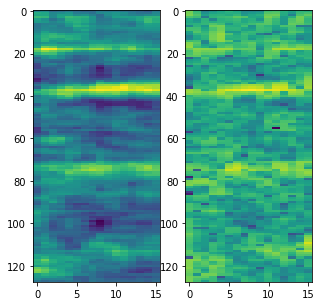

In [13]:

for images, labels in train_dl: 
    print("spectrogram shape: ", images.shape)
    out = autoencoder(images)
    print("output shape: ", out.shape)
    break 
    
img = out[1][0].detach().cpu()
print(img.shape) 
import matplotlib.pyplot as plt 
fig, axs = plt.subplots(1,2,figsize = (5,5))
axs[0].imshow(img, aspect = 'auto')
axs[1].imshow(images[1][0].detach().cpu(), aspect = 'auto')

In [14]:
out_list = [[] for i in range(3)]
imgs = [[] for i in range(3)]
mse_per_image = nn.MSELoss(reduction='none')
for images, labels in test_dl:
    print(images.shape)
    out = autoencoder(images)
    losses = torch.sum(mse_per_image(images, out).detach().cpu(), dim =(1,2,3))/(images.shape[-1]*images.shape[-2])
    losses = losses.numpy()
    for i in range(len(images)):
        out_list[int(labels[i].detach().cpu())].append(losses[i])
        imgs[int(labels[i].detach().cpu())].append(images[i])


torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])
torch.Size([150, 1, 128, 16])


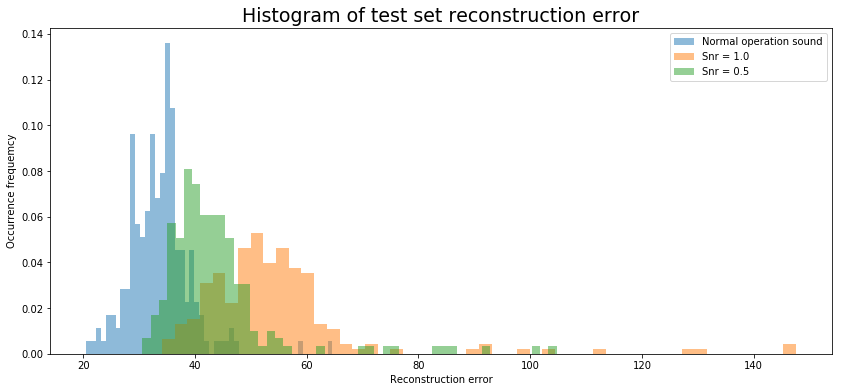

torch.Size([1, 128, 16])


In [15]:

fig, ax = plt.subplots(1,1,figsize = (14,6))

ax.title.set_text("Histogram of test set reconstruction error")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Snr = 1.0", "Snr = 0.5"]

for i in range(len(out_list)):
    ax.hist(bins = 50, x=out_list[i], alpha = 0.5, label = labels[i], density = True)

ax.set_xlabel("Reconstruction error")
ax.set_ylabel("Occurrence frequemcy")
ax.legend()
plt.show()

min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))


torch.Size([1, 128, 16])
torch.Size([128, 16])


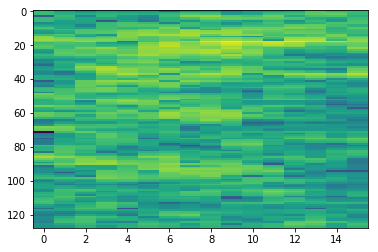

In [16]:
min_img = imgs[1][out_list[1].index(min(out_list[1]))]
print(np.shape(min_img))
im = min_img.detach().cpu().squeeze()
print(np.shape(im))
plt.imshow(im, aspect = "auto")

The difference is 0.15995401711562876


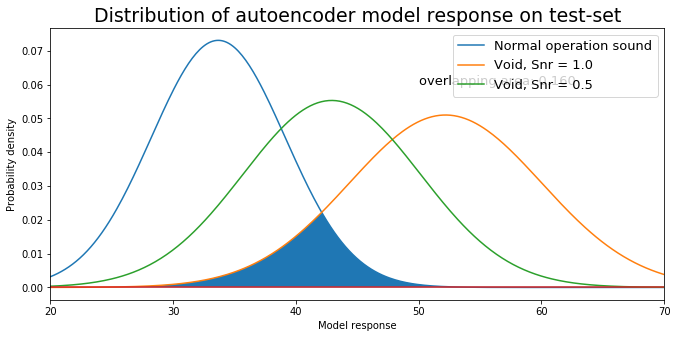

In [17]:
import scipy.integrate
from scipy.stats import norm
fig, ax = plt.subplots(1,1,figsize = (11,5))
integrate = scipy.integrate.quad
ax.title.set_text("Distribution of autoencoder model response on test-set")
ax.title.set_fontsize(19)
labels = ["Normal operation sound", "Void, Snr = 1.0", "Void, Snr = 0.5"]
x = np.linspace(20,140,800)
SMALL_SIZE = 13
MEDIUM_SIZE = 13
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
 
for i in range(len(out_list)):
    truncated = [out_list[i][j] if out_list[i][j]<=65 else 65 for j in range(len(out_list[i]))]
    if i ==1: 
        m_old = m
        s_old = s
        y_old = y
    m = np.mean(truncated)
    s = np.sqrt(np.var(truncated))
    y = norm.pdf(x,m,s)

    if i==1:
        under_fun = lambda x: min(norm.pdf(x,m,s), norm.pdf(x,m_old, s_old))
        diff = integrate(under_fun, 10,60)
        print(f"The difference is {diff[0]}")
        y_min = [min(y[i],y_old[i]) for i in range(len(y))]
        ax.fill_between(x, y_min)
    ax.plot(x,y, label = labels[i])
    


ax.plot(x, [0 for i in range(len(x))])
ax.set_xlim([20,70])
ax.set_xlabel("Model response")
ax.set_ylabel("Probability density")
ax.text(50,0.06,f"overlapping area: {diff[0]:.3f}")
ax.legend()
plt.show()


The aoc score is 0.974 for snr =1
The aoc score is 0.889 for snr =0.5


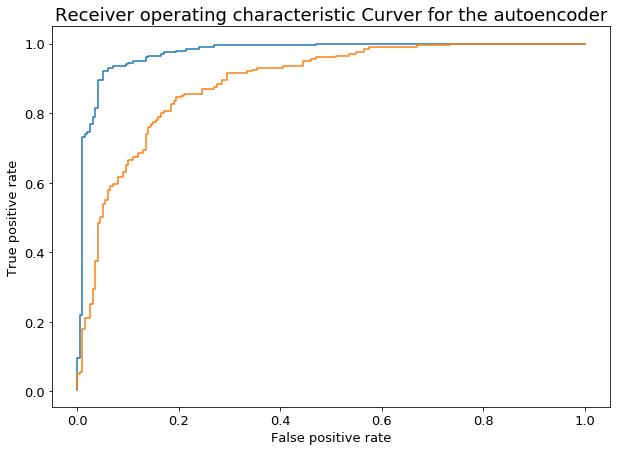

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import pickle 
scores1 = out_list[0]+out_list[1]
y1 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[1]))]
fpr1, tpr1, thresholds1 = roc_curve(y1, scores1, pos_label = 1)

aoc_snr1 = roc_auc_score(y1,scores1)
print(f"The aoc score is {aoc_snr1:.3f} for snr =1")

scores2 = out_list[0]+out_list[2]
y2 = [0 for i in range(len(out_list[0]))]+[1 for i in range(len(out_list[2]))]
fpr2, tpr2, thresholds2= roc_curve(y2, scores2, pos_label = 1)

aoc_snr2 = roc_auc_score(y2,scores2)
print(f"The aoc score is {aoc_snr2:.3f} for snr =0.5")

with open("auto_roc.txt", "wb") as f: 
    pickle.dump({"fpr1":fpr1, "tpr1":tpr1, "thresholds1":thresholds1,"fpr2":fpr2, "tpr2":tpr2, "thresholds2":thresholds2
                , "scores1": scores1, "scores2": scores2, "y1": y1, "y2":y2},f)

fig, ax = plt.subplots(1,1, figsize = (10,7))

ax.title.set_text("Receiver operating characteristic Curver for the autoencoder")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.plot(fpr1, tpr1)
ax.plot(fpr2, tpr2)

In [150]:
import librosa

test_piece, sr = librosa.load("./data/synthetic/7_with_void.wav")

score = []
i =0 
my_len = 16*512-1
while i<len(test_piece)-my_len:
    piece = test_piece[i:i+my_len]
    xt  = librosa.power_to_db(librosa.feature.melspectrogram(piece, n_mels = 128, fmax = 1024))
    xt = torch.tensor(xt).float()
    xt = torch.unsqueeze(xt,0)
    xt = torch.unsqueeze(xt,0)
    xt = xt.to(device)
    recons = autoencoder(xt)
    loss = mse_per_image(recons, xt)
    
    score.append(float(torch.sum(loss.detach().cpu())/(xt.shape[-1]*xt.shape[-2])))
    i+= 512
    


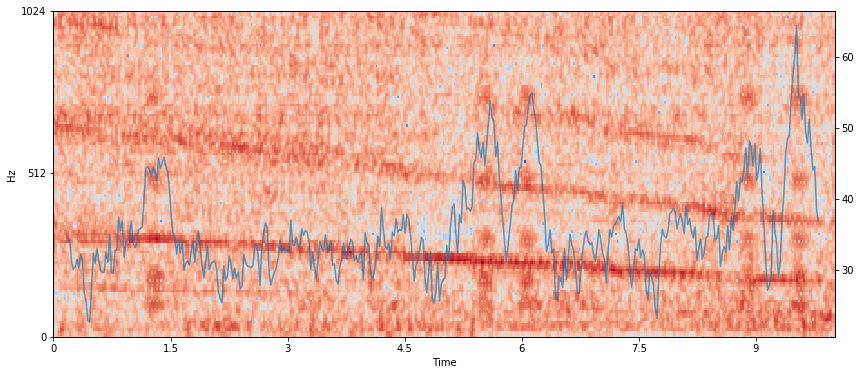

In [157]:
import librosa.display
x =[]
test_xt = librosa.power_to_db(librosa.feature.melspectrogram(test_piece, n_mels =128, fmax= 1024))
fig = plt.gcf()
fig.set_size_inches(14,6)
ax = plt.subplot()

ax2 = ax.twinx()
librosa.display.specshow(test_xt, fmax = 1024, y_axis = "mel", ax = ax, x_axis = 'time')
for i in range(len(score)):
    x.append((i+8)*(512/sr))
ax2.plot(x,score, alpha = 0.7)

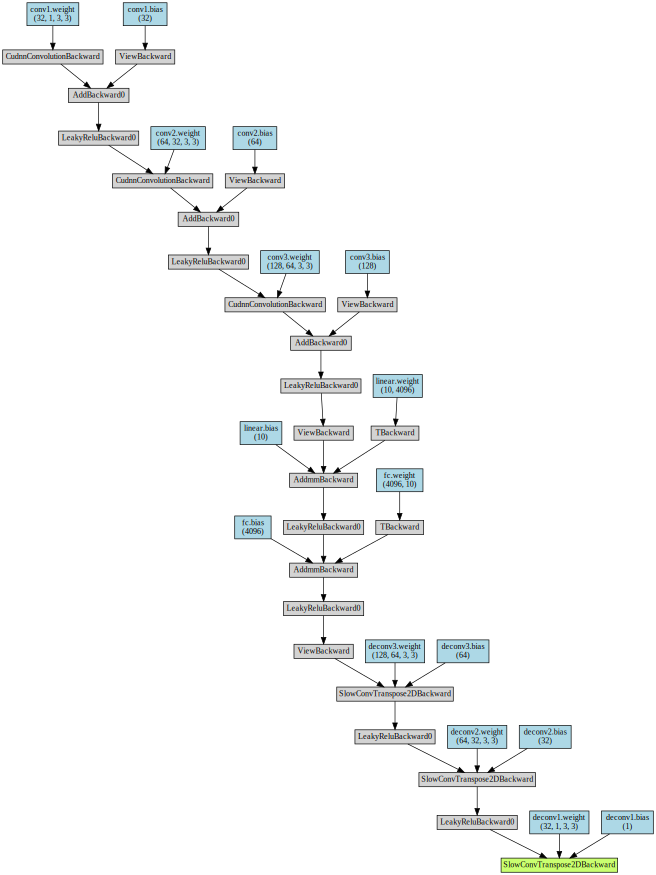

In [161]:
from torchviz import make_dot 
make_dot(recons, params = dict(autoencoder.named_parameters()))

In [163]:
from torch.utils.tensorboard import SummaryWriter 
writer = SummaryWriter("runs/ae_experiment_1")

In [169]:
writer.add_graph(autoencoder,images)
